## Modified Slim

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
from matplotlib import pyplot as plt
import os
import deepxde as dde
from utils.gs_solovev_sol import GS_Linear

######################
# ITER shape #
######################
eps = 0.32
kappa = 1.7
delta = 0.33
Amax = 10
num_A = 10
Arange = np.linspace(-Amax, Amax, num_A)

N1 = - (1 + np.arcsin(delta)) ** 2 / (eps * kappa ** 2)
N2 = (1 - np.arcsin(delta)) ** 2 / (eps * kappa ** 2)
N3 = - kappa / (eps * np.cos(np.arcsin(delta)) ** 2)

def gen_traindata(num):
    ######################
    # ITER Configuration #
    ######################

    N = num
    center = np.array([[0.0, 0.0, 0.0]])
    tau = np.linspace(0, 2 * np.pi, N)
    R_ellipse = np.outer(1 + eps * np.cos(tau + np.arcsin(delta) * np.sin(tau)),
                             np.ones(num_A)
                             )
    Z_ellipse = np.outer(eps * kappa * np.sin(tau),
                             np.ones(num_A)
                             )
    A_ellipse = np.outer(np.ones(N), Arange)
    x_ellipse = np.transpose(
        np.asarray([R_ellipse, Z_ellipse, A_ellipse]), 
        [1, 2, 0]
    )
    x_ellipse = x_ellipse.reshape(N * num_A, 3)
    uvals = np.zeros(len(x_ellipse)).reshape(len(x_ellipse), 1)
    return x_ellipse, uvals


def pde_solovev(x, u):
    psi = u[:, 0:1]
    psi_r = dde.grad.jacobian(psi, x, i=0, j=0)
    psi_rr = dde.grad.hessian(psi, x, i=0, j=0)
    psi_zz = dde.grad.hessian(psi, x, i=1, j=1)
    A = x[:, 2:3]
    GS = psi_rr - psi_r / x[:, 0:1] + psi_zz - (1 - A) * x[:, 0:1] ** 2 - A
    return GS

def psi_r(x,u):
    return dde.grad.jacobian(u, x, i=0, j=0)
def psi_z(x,u):
    return  dde.grad.jacobian(u, x, i=0, j=1)
def psi_rr(x, u):
    return dde.grad.hessian(u, x, i=0, j=0)
def psi_zz(x, u):
    return dde.grad.hessian(u, x, i=1, j=1)

def boundary_outer(x, on_boundary):
    return on_boundary and np.isclose([x[0], x[1]], [1 + eps, 0]).all()
def boundary_inner(x, on_boundary):
    return on_boundary and np.isclose([x[0], x[1]], [1 - eps, 0]).all()
def boundary_high(x, on_boundary):
    return on_boundary and np.isclose([x[0], x[1]], [1 - delta * eps, kappa * eps]).all()

spatial_domain = dde.geometry.Ellipse_A(eps, kappa, delta, Amax=Amax) 

x, u = gen_traindata(200)

n_test = 100

bc135 = dde.PointSetBC(x,u)

data = dde.data.PDE(
    spatial_domain,
    pde_solovev,
    [bc135],
    num_domain=512,
    num_boundary=0,
    num_test=n_test,
    train_distribution="LHS"
)


Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



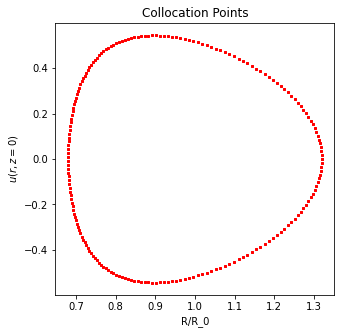

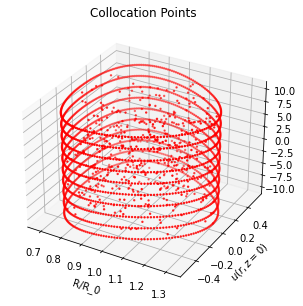

In [2]:
# Plot collocation points for visual check
fig, ax = plt.subplots(1, figsize=(5, 5))
ax.scatter(data.train_x_bc[:, 0], data.train_x_bc[:, 1], s=2, color='r')
ax.set_title('Collocation Points')
ax.set_xlabel('R/R_0')
ax.set_ylabel(r'$u(r,z=0)$')

fig =plt.figure(2, figsize=(5,5))
ax = fig.add_subplot(projection='3d')
ax.scatter(
    data.train_x[:, 0], 
    data.train_x[:, 1], 
    data.train_x[:, 2], 
    s=2, 
    color='r'
)
ax.set_title('Collocation Points')
ax.set_xlabel('R/R_0')
ax.set_ylabel(r'$u(r,z=0)$')
plt.show()

## Train Model

Compiling model...
Building feed-forward neural network...
'build' took 0.114379 s



/Users/alankaptanoglu/deepxde_copy/deepxde/nn/tensorflow_compat_v1/fnn.py:110: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_constraint=self.kernel_constraint,


'compile' took 1.475308 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric
0         [4.17e+00, 1.31e+00]    [3.77e+00, 1.31e+00]    []  
10        [3.58e+00, 1.31e-01]    [3.02e+00, 1.31e-01]    []  
20        [3.44e+00, 5.10e-02]    [2.75e+00, 5.10e-02]    []  
30        [3.25e+00, 2.44e-02]    [2.62e+00, 2.44e-02]    []  
40        [2.27e+00, 4.51e-02]    [1.80e+00, 4.51e-02]    []  
50        [9.05e-01, 4.22e-02]    [5.96e-01, 4.22e-02]    []  
60        [7.63e-01, 4.20e-02]    [7.97e-01, 4.20e-02]    []  
70        [4.52e-01, 3.64e-02]    [3.70e-01, 3.64e-02]    []  
80        [2.65e-01, 3.74e-02]    [2.45e-01, 3.74e-02]    []  
90        [2.15e-01, 4.02e-02]    [2.35e-01, 4.02e-02]    []  
100       [1.83e-01, 4.03e-02]    [1.99e-01, 4.03e-02]    []  

Best model at step 100:
  train loss: 2.24e-01
  test loss: 2.39e-01
  test metric: []

'train' took 3.275091 s

Saving loss history to ./cefron/ITER/runs/network_s

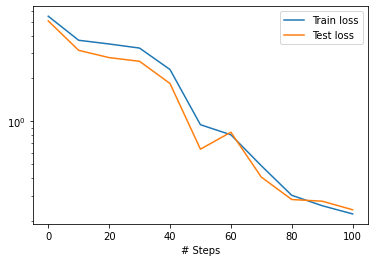

In [3]:
DATE = "10122022"
CONFIG = "ITER"
LR = 2e-2
DEPTH = 2
BREADTH = 40
run = "01_100Adam_BFGS"
AF = "swish"
RUN_NAME = f"network_sweep_{DATE}_depth0{DEPTH}_breadth{BREADTH}_{AF}_lr{LR}-varying-short_lw1-10_{run}"
PATH = f"./cefron/{CONFIG}/runs/{RUN_NAME}"

# Check whether the specified path exists or not
isExist = os.path.exists(PATH)
if not isExist:
  os.makedirs(PATH)
  print("The new directory is created!")

net = dde.maps.FNN([3] + DEPTH * [BREADTH] + [1], AF, "Glorot normal")

model = dde.Model(data, net)
decay_rate = 1.0
for i in range(1):
  # Compile, train and save model
  model.compile(
      "adam", lr=LR/(decay_rate * (i + 1)),
      loss_weights=[1, 1]
  )
  loss_history, train_state = model.train(epochs=100, display_every=10)
  dde.saveplot(
      loss_history, 
      train_state, 
      issave=True, 
      isplot=True,
      output_dir=PATH
  )

#### After BFGS

Compiling model...
'compile' took 1.239423 s

Training model...

Step      Train loss              Test loss               Test metric
100       [1.83e-01, 4.03e+00]    [1.99e-01, 4.03e+00]    []  
110       [7.93e-01, 1.54e+00]    [7.93e-01, 1.54e+00]        
120       [8.64e-01, 6.23e-01]    [8.64e-01, 6.23e-01]        
130       [6.83e-01, 4.38e-01]    [6.83e-01, 4.38e-01]        
140       [7.00e-01, 2.38e-01]    [7.00e-01, 2.38e-01]        
150       [6.14e-01, 1.20e-01]    [6.14e-01, 1.20e-01]        
160       [5.13e-01, 1.08e-01]    [5.13e-01, 1.08e-01]        
170       [4.42e-01, 8.36e-02]    [4.42e-01, 8.36e-02]        
180       [3.67e-01, 7.42e-02]    [3.67e-01, 7.42e-02]        
190       [2.85e-01, 6.73e-02]    [2.85e-01, 6.73e-02]        
200       [2.15e-01, 7.66e-02]    [2.15e-01, 7.66e-02]        
210       [1.75e-01, 8.24e-02]    [1.75e-01, 8.24e-02]        
220       [1.30e-01, 5.88e-02]    [1.30e-01, 5.88e-02]        
230       [1.18e-01, 5.30e-02]    [1.18e-01, 5

1370      [3.59e-04, 9.01e-04]    [3.59e-04, 9.01e-04]        
1380      [3.63e-04, 8.89e-04]    [3.63e-04, 8.89e-04]        
1390      [3.63e-04, 8.74e-04]    [3.63e-04, 8.74e-04]        
1400      [3.60e-04, 8.63e-04]    [3.60e-04, 8.63e-04]        
1410      [3.52e-04, 8.46e-04]    [3.52e-04, 8.46e-04]        
1420      [3.49e-04, 8.31e-04]    [3.49e-04, 8.31e-04]        
1430      [3.57e-04, 8.02e-04]    [3.57e-04, 8.02e-04]        
1440      [3.38e-04, 8.04e-04]    [3.38e-04, 8.04e-04]        
1450      [3.34e-04, 7.99e-04]    [3.34e-04, 7.99e-04]        
1460      [3.36e-04, 7.91e-04]    [3.36e-04, 7.91e-04]        
1470      [3.39e-04, 7.81e-04]    [3.39e-04, 7.81e-04]        
1480      [3.39e-04, 7.71e-04]    [3.39e-04, 7.71e-04]        
1490      [3.43e-04, 7.60e-04]    [3.43e-04, 7.60e-04]        
1500      [3.47e-04, 7.50e-04]    [3.47e-04, 7.50e-04]        
1510      [3.54e-04, 7.38e-04]    [3.54e-04, 7.38e-04]        
1520      [3.62e-04, 7.26e-04]    [3.62e-04, 7.26e-04] 

2680      [2.31e-04, 2.30e-04]    [2.31e-04, 2.30e-04]        
2690      [2.30e-04, 2.29e-04]    [2.30e-04, 2.29e-04]        
2700      [2.35e-04, 2.16e-04]    [2.35e-04, 2.16e-04]        
2710      [2.22e-04, 2.19e-04]    [2.22e-04, 2.19e-04]        
2720      [2.19e-04, 2.16e-04]    [2.19e-04, 2.16e-04]        
2730      [2.13e-04, 2.17e-04]    [2.13e-04, 2.17e-04]        
2740      [2.10e-04, 2.17e-04]    [2.10e-04, 2.17e-04]        
2750      [2.07e-04, 2.17e-04]    [2.07e-04, 2.17e-04]        
2760      [2.07e-04, 2.15e-04]    [2.07e-04, 2.15e-04]        
2770      [2.07e-04, 2.14e-04]    [2.07e-04, 2.14e-04]        
2780      [2.09e-04, 2.12e-04]    [2.09e-04, 2.12e-04]        
2790      [2.10e-04, 2.08e-04]    [2.10e-04, 2.08e-04]        
2800      [2.07e-04, 2.09e-04]    [2.07e-04, 2.09e-04]        
2810      [2.08e-04, 2.07e-04]    [2.08e-04, 2.07e-04]        
2820      [2.07e-04, 2.06e-04]    [2.07e-04, 2.06e-04]        
2830      [2.06e-04, 2.01e-04]    [2.06e-04, 2.01e-04] 

3990      [1.21e-04, 7.02e-05]    [1.21e-04, 7.02e-05]        
4000      [1.19e-04, 7.11e-05]    [1.19e-04, 7.11e-05]        
4010      [1.20e-04, 6.95e-05]    [1.20e-04, 6.95e-05]        
4020      [1.21e-04, 6.72e-05]    [1.21e-04, 6.72e-05]        
4030      [1.19e-04, 6.68e-05]    [1.19e-04, 6.68e-05]        
4040      [1.18e-04, 6.67e-05]    [1.18e-04, 6.67e-05]        
4050      [1.17e-04, 6.72e-05]    [1.17e-04, 6.72e-05]        
4060      [1.17e-04, 6.67e-05]    [1.17e-04, 6.67e-05]        
4070      [1.17e-04, 6.65e-05]    [1.17e-04, 6.65e-05]        
4080      [1.17e-04, 6.64e-05]    [1.17e-04, 6.64e-05]        
4090      [1.17e-04, 6.60e-05]    [1.17e-04, 6.60e-05]        
4100      [1.16e-04, 6.56e-05]    [1.16e-04, 6.56e-05]        
4110      [1.16e-04, 6.50e-05]    [1.16e-04, 6.50e-05]        
4120      [1.16e-04, 6.48e-05]    [1.16e-04, 6.48e-05]        
4130      [1.13e-04, 6.64e-05]    [1.13e-04, 6.64e-05]        
4140      [1.14e-04, 6.53e-05]    [1.14e-04, 6.53e-05] 

5300      [4.01e-05, 3.88e-05]    [4.01e-05, 3.88e-05]        
5310      [3.93e-05, 3.86e-05]    [3.93e-05, 3.86e-05]        
5320      [3.95e-05, 3.79e-05]    [3.95e-05, 3.79e-05]        
5330      [3.94e-05, 3.74e-05]    [3.94e-05, 3.74e-05]        
5340      [3.87e-05, 3.75e-05]    [3.87e-05, 3.75e-05]        
5350      [3.76e-05, 3.79e-05]    [3.76e-05, 3.79e-05]        
5360      [3.73e-05, 3.77e-05]    [3.73e-05, 3.77e-05]        
5370      [3.64e-05, 3.82e-05]    [3.64e-05, 3.82e-05]        
5380      [3.59e-05, 3.83e-05]    [3.59e-05, 3.83e-05]        
5390      [3.59e-05, 3.80e-05]    [3.59e-05, 3.80e-05]        
5400      [3.62e-05, 3.73e-05]    [3.62e-05, 3.73e-05]        
5410      [3.63e-05, 3.68e-05]    [3.63e-05, 3.68e-05]        
5420      [3.62e-05, 3.67e-05]    [3.62e-05, 3.67e-05]        
5430      [3.61e-05, 3.67e-05]    [3.61e-05, 3.67e-05]        
5440      [3.62e-05, 3.65e-05]    [3.62e-05, 3.65e-05]        
5450      [3.59e-05, 3.66e-05]    [3.59e-05, 3.66e-05] 

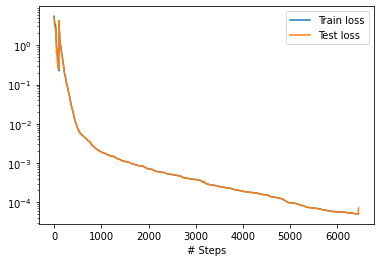

In [4]:
# Compile, train and save model
model.compile(
    "L-BFGS-B",
    loss_weights=[1, 100]
)
loss_history, train_state = model.train(epochs=1000, display_every=10)
dde.saveplot(
    loss_history, 
    train_state, 
    issave=True, 
    isplot=True,
    output_dir=PATH
)


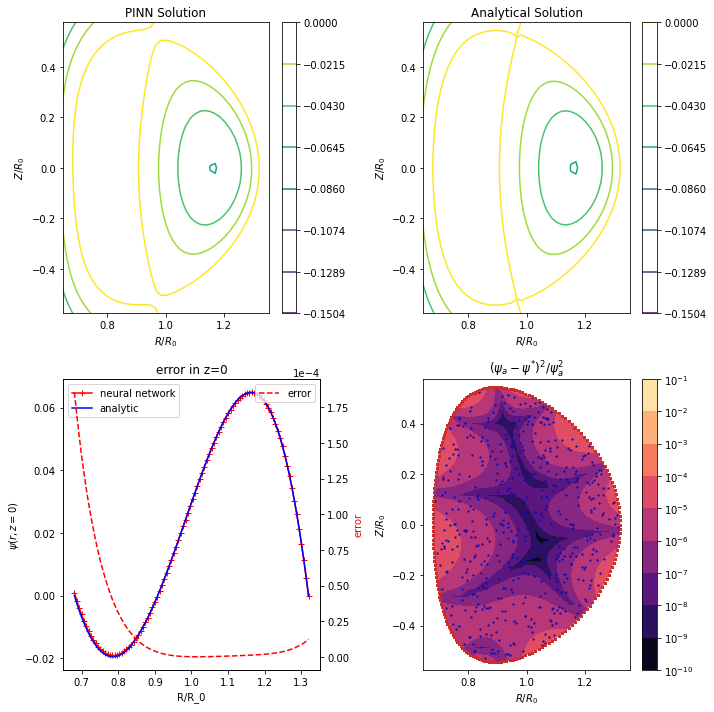

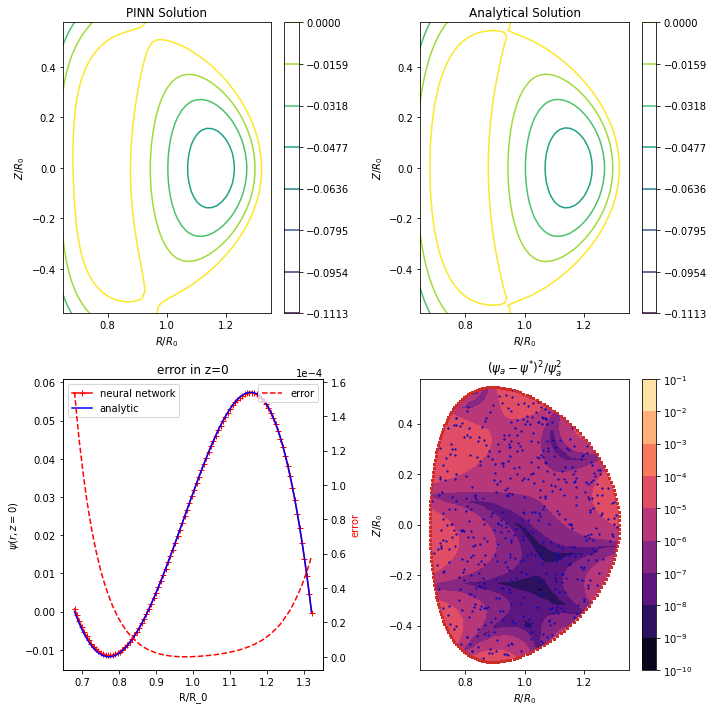

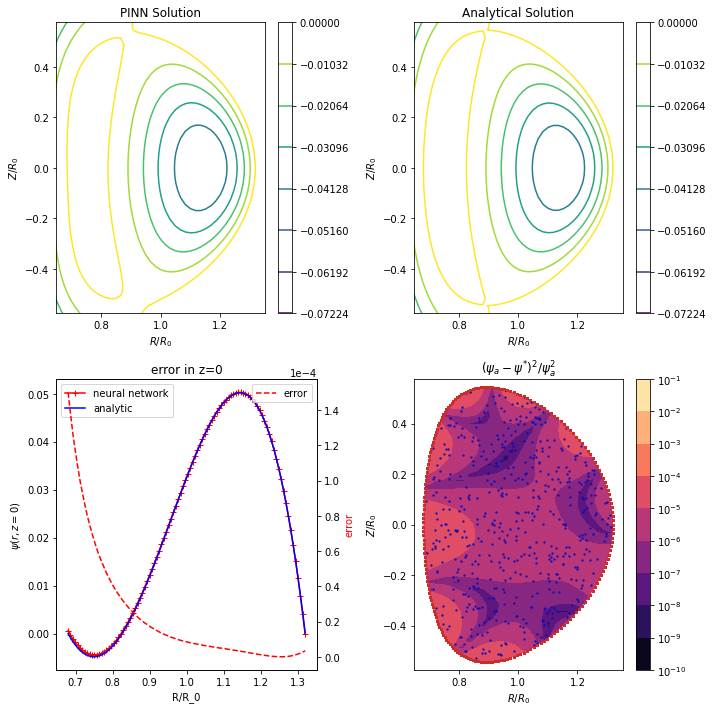

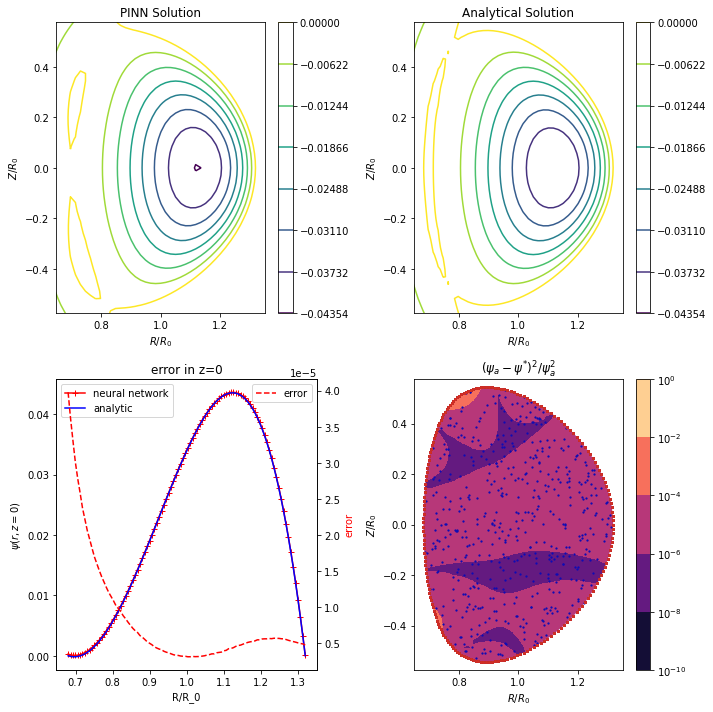

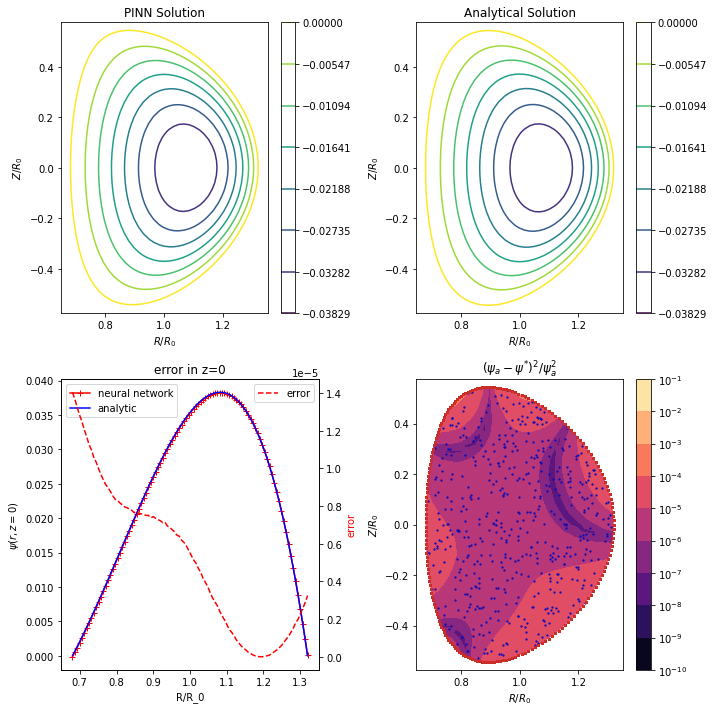

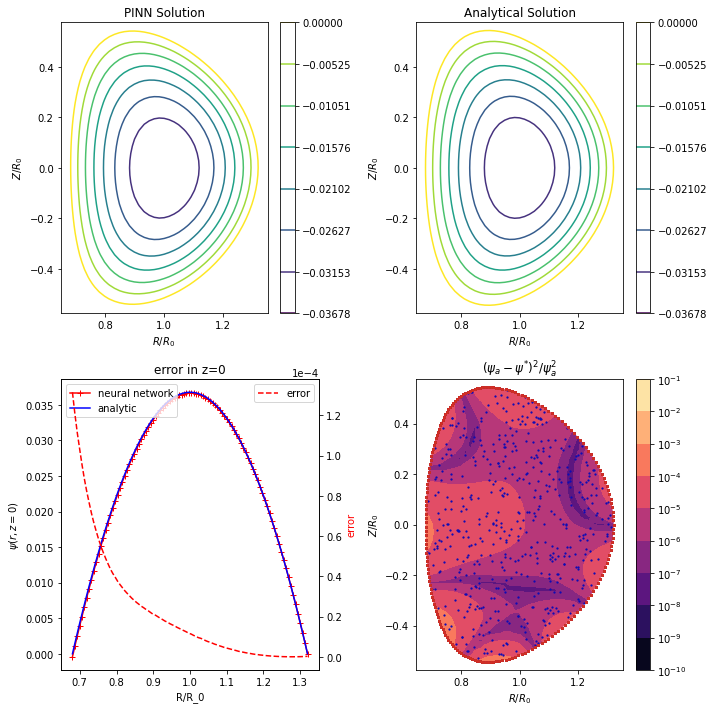

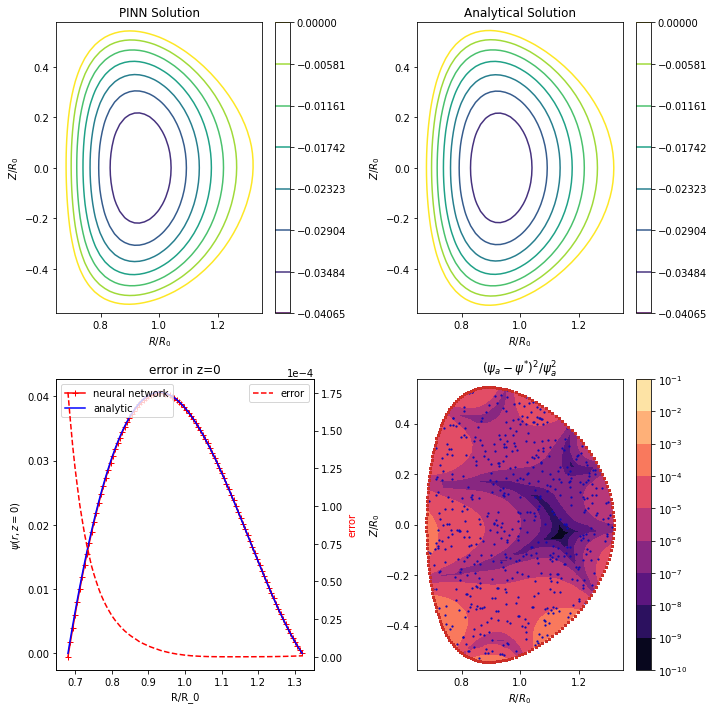

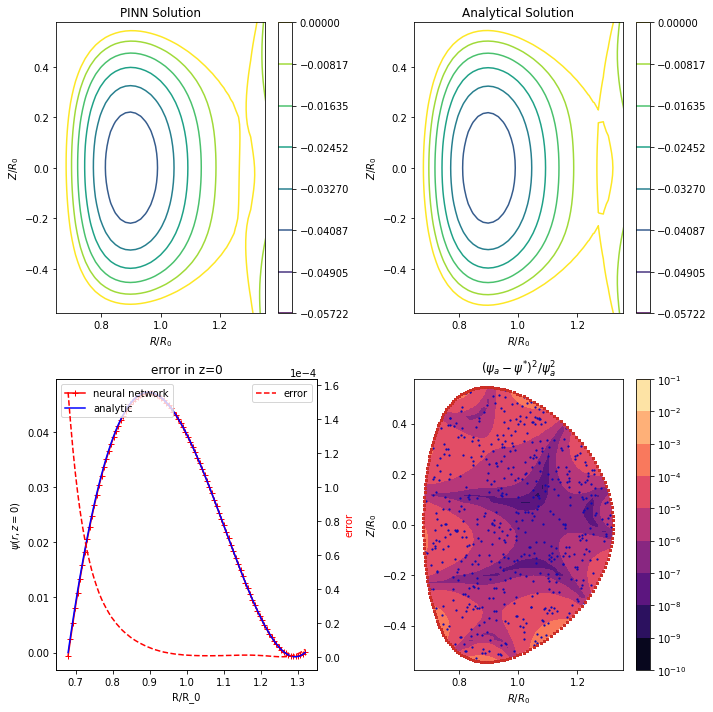

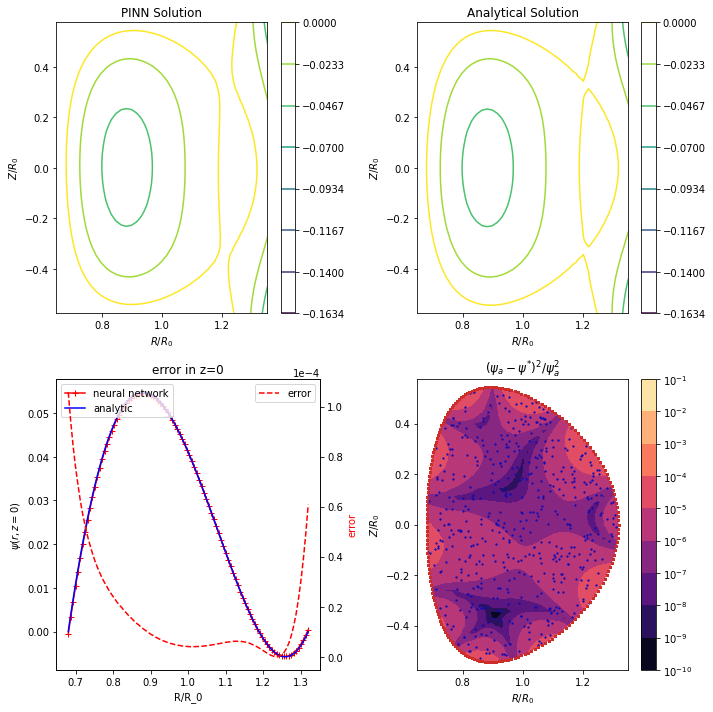

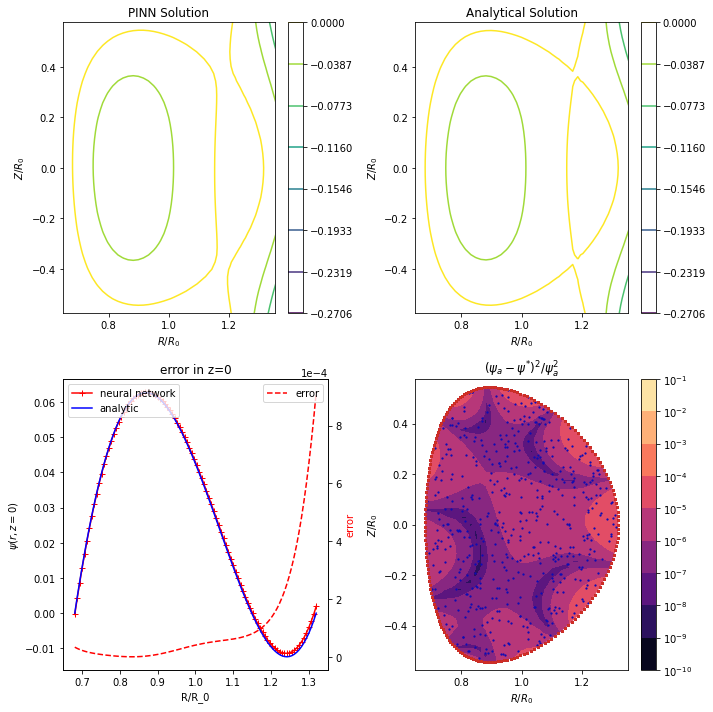

In [5]:
# Evaluation
from utils.utils import *
ITER = GS_Linear(eps=eps, kappa=kappa, delta=delta)
for i in range(num_A):
    ITER.get_BCs(A=Arange[i])
    ITER.solve_coefficients()
    xfull, yfull, psi_pred_full, psi_true_full, error = evaluate(ITER, model)
    X_test = spatial_domain.random_points(333)
    plot_summary_figure(ITER, model, X_test, PATH)